# Hierarchical clustering

In [ ]:
#| default_exp clustering

## Overview

This module provides tools for computing pairwise distances between PSSMs (Position-Specific Scoring Matrices), performing hierarchical clustering, and visualizing results as dendrograms.

---

**Distance Computation**

`get_1d_distance(df, func_flat)` — Computes pairwise distances between all rows in a dataframe using a specified distance function. Returns a 1D condensed distance array suitable for scipy's linkage functions.

```python
dist = get_1d_distance(
    df=pssms.head(10),      # dataframe where each row is a flattened PSSM
    func_flat=js_divergence_flat,  # distance function taking two rows, returns scalar
)
```

`get_1d_js(df)` — Convenience wrapper that computes pairwise JS (Jensen-Shannon) divergence distances.

```python
dist = get_1d_js(
    df=pssms.head(20),  # dataframe of flattened PSSMs
)
```

`get_1d_distance_parallel(df, func_flat, max_workers, chunksize)` — Parallelized version for large dataframes.

```python
dist = get_1d_distance_parallel(
    df=pssms,              # dataframe of flattened PSSMs
    func_flat=js_divergence_flat,  # distance function
    max_workers=4,         # number of parallel workers
    chunksize=100,         # items per worker batch
)
```

`get_1d_js_parallel(df, **kwargs)` — Parallelized JS divergence with same interface as above.

---

**Linkage Matrix**

`get_Z(pssms, func_flat, parallel)` — Computes the linkage matrix Z from a PSSM dataframe. This is the main entry point combining distance computation and hierarchical clustering.

```python
Z = get_Z(
    pssms=pssms.head(100),         # dataframe of flattened PSSMs
    func_flat=js_divergence_flat,  # distance function (default: JS divergence)
    parallel=True,                 # use parallel computation for speed
)
```

---

**Visualization**

`plot_dendrogram(Z, color_thr, dense, line_width, title, scale, **kwargs)` — Plots a horizontal dendrogram from linkage matrix Z. Passes additional kwargs to scipy's `dendrogram()`.

```python
plot_dendrogram(
    Z=Z,                  # linkage matrix from get_Z()
    color_thr=0.07,       # distance threshold for coloring branches
    dense=7,              # density control (higher = more compact rows)
    line_width=1,         # width of dendrogram lines
    title="My Cluster",   # optional plot title
    scale=1,              # figure size multiplier
    labels=labels,        # custom leaf labels (from get_pssm_seq_labels)
    truncate_mode='lastp',  # scipy kwarg: show only last p merged clusters
    p=40,                 # scipy kwarg: number of leaves to show
)
```

---

**PSSM Labeling**

`pssm_to_seq(pssm_df, thr, clean_center)` — Converts a 2D PSSM back to a consensus sequence string. Uses brackets for multiple high-probability amino acids and `*` to mark the phosphorylation center.

```python
seq = pssm_to_seq(
    pssm_df=recover_pssm(pssms.iloc[0]),  # 2D PSSM (rows=AAs, cols=positions)
    thr=0.2,           # probability threshold to include amino acid
    clean_center=True, # keep only s/t/y at center position
)
# Returns e.g.: '..RR.[s/t]*....'
```

`get_pssm_seq_labels(pssms, count_map, thr)` — Generates dendrogram labels combining the PSSM index name with its consensus sequence. Optionally includes sample counts.

```python
labels = get_pssm_seq_labels(
    pssms=pssms.head(10),  # dataframe of flattened PSSMs
    count_map=count_dict,  # optional dict {index: count} for sample sizes
    thr=0.3,               # probability threshold for consensus sequence
)
# Returns e.g.: ['AKT1 (n=60): ..RR.[s/t]*....', ...]
```

---

**Full Pipeline Example**

```python
# 1. Load and subset data
pssms = Data.get_pspa_scale().head(100)

# 2. Compute linkage matrix
Z = get_Z(
    pssms=pssms,
    parallel=True,
)

# 3. Generate labels with consensus sequences
labels = get_pssm_seq_labels(
    pssms=pssms,
    thr=0.3,
)

# 4. Plot dendrogram
plot_dendrogram(
    Z=Z,
    dense=8,
    labels=labels,
    truncate_mode='lastp',
    p=40,
)
```

## Setup

In [ ]:
#| export
import pandas as pd,numpy as np
from katlas.data import *
from katlas.pssm.compare import js_divergence_flat
from katlas.pssm.core import recover_pssm
from katlas.plot import set_sns
from tqdm import tqdm
from functools import partial
from tqdm.contrib.concurrent import process_map
from fastcore.meta import delegates
from scipy.cluster.hierarchy import linkage,dendrogram
from matplotlib import pyplot as plt

## Distance

In [ ]:
pssms=Data.get_pspa_scale()

In [ ]:
#| export
def get_1d_distance(df,func_flat):
    "Compute 1D distance for each row in a dataframe given a distance function "
    n = len(df)
    dist = []
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            d = func_flat(df.iloc[i], df.iloc[j])
            dist.append(d)
    return np.array(dist)

In [ ]:
# return 1d distance
get_1d_distance(pssms.head(),js_divergence_flat)


  0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 5/5 [00:00<00:00, 296.35it/s]

array([0.08286125, 0.08577978, 0.08798376, 0.08501009, 0.00215832,
       0.07937984, 0.07066437, 0.08348296, 0.07361695, 0.0042525 ])

In [ ]:
#| export
def get_1d_js(df): 
    "Compute 1D distance using JS divergence."
    return get_1d_distance(df,js_divergence_flat)

In [ ]:
distance = get_1d_js(pssms.head(20))


  0%|          | 0/20 [00:00<?, ?it/s]


 25%|██▌       | 5/20 [00:00<00:00, 45.19it/s]


 65%|██████▌   | 13/20 [00:00<00:00, 62.03it/s]


100%|██████████| 20/20 [00:00<00:00, 78.69it/s]

Parallel computing to accelerate when flattened pssms are too many in a df:

In [ ]:
#| hide
#| export
def get_distance(pair, df, func):
    i, j = pair
    return func(df.iloc[i], df.iloc[j])

In [ ]:
#| export
def get_1d_distance_parallel(df, func_flat, max_workers=4, chunksize=100):
    "Parallel compute 1D distance for each row in a dataframe given a distance function "
    n = len(df)
    index_pairs = [(i, j) for i in range(n) for j in range(i + 1, n)]

    bound_worker = partial(get_distance, df=df, func=func_flat)

    dist = process_map(bound_worker, index_pairs, max_workers=max_workers, chunksize=chunksize)
    return np.array(dist)

```python
get_1d_distance_parallel(pssms.head(),js_divergence_flat)
```

In [ ]:
#| export
@delegates(get_1d_distance_parallel)
def get_1d_js_parallel(df, func_flat=js_divergence_flat, **kwargs): 
    "Compute 1D distance matrix using JS divergence."
    return get_1d_distance_parallel(df, func_flat=func_flat, **kwargs)

```python
get_1d_js_parallel(pssms.head())
```

In [ ]:
#| export
def get_Z(pssms,func_flat=js_divergence_flat,parallel=True):
    "Get linkage matrix Z from pssms dataframe"
    distance = get_1d_distance_parallel(pssms,func_flat=func_flat) if parallel else get_1d_distance(pssms,func_flat=func_flat)
    Z = linkage(distance, method='ward')
    return Z

In [ ]:
Z = get_Z(pssms.head(10),parallel=False)


  0%|          | 0/10 [00:00<?, ?it/s]


100%|██████████| 10/10 [00:00<00:00, 165.83it/s]

In [ ]:
Z[:5]

array([[1.00000000e+00, 2.00000000e+00, 2.15831816e-03, 2.00000000e+00],
       [3.00000000e+00, 4.00000000e+00, 4.25249792e-03, 2.00000000e+00],
       [5.00000000e+00, 1.10000000e+01, 4.65130779e-03, 3.00000000e+00],
       [6.00000000e+00, 7.00000000e+00, 5.89059764e-03, 2.00000000e+00],
       [1.00000000e+01, 1.30000000e+01, 9.31412253e-03, 4.00000000e+00]])

In [ ]:
#| export
def plot_dendrogram(Z,
                    color_thr=0.07,
                    dense=7, # the higher the more dense for each row
                    line_width=1,
                    title=None,
                    scale=1,
                    **kwargs):
    length = (len(Z) + 1) // dense
    
    plt.figure(figsize=(5*scale,length*scale))
    with plt.rc_context({'lines.linewidth': line_width}):
        dendrogram(
            Z,
            orientation='left',
            leaf_font_size=7,
            color_threshold=color_thr,
            **kwargs
        )
    if title is not None: plt.title(title)
    plt.xlabel('Distance')
    # plt.savefig(output, bbox_inches='tight')
    # plt.close()
    ax = plt.gca()
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_visible(False)

In [ ]:
set_sns(100)

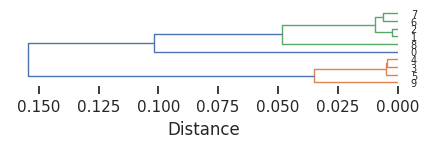

In [ ]:
plot_dendrogram(Z,dense=7,line_width=1)

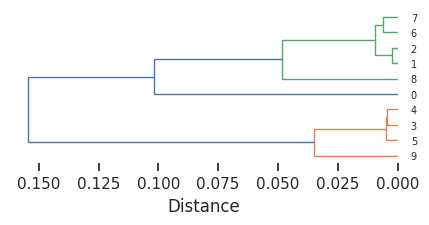

In [ ]:
plot_dendrogram(Z,dense=4)

In [ ]:
#| export
def pssm_to_seq(pssm_df, 
                thr=0.2, # threshold of probability to show in sequence
                clean_center=True, # if true, zero out non-last three values in position 0 (keep only s,t,y values at center)
                ):
    "Represent PSSM in string sequence of amino acids"
    
    pssm_df = pssm_df.copy()
    if clean_center:
        pssm_df.loc[pssm_df.index[:-3], 0] = 0  # keep only s,t,y in center 0 position

    pssm_df.index = pssm_df.index.map(lambda x: x.replace('pS', 's').replace('pT', 't').replace('pY', 'y'))

    consensus = []
    for i, col in enumerate(pssm_df.columns):
        # consider the case where sum for the position is 0
        column_vals = pssm_df[col]
        if column_vals.sum() == 0:
            symbol = '_'
        else:
            top = column_vals.nlargest(3)
            passing = [aa for aa, prob in zip(top.index, top.values) if prob > thr]

            if not passing:
                symbol = '.'
            elif len(passing) == 1:
                symbol = passing[0]
            else:
                symbol = f"[{'/'.join(passing)}]"
                
        if col == 0:  # center position
            if symbol.startswith('['):
                symbol = symbol[:-1] + ']*'
            else:
                symbol += '*'

        consensus.append(symbol)

    return ''.join(consensus)

In [ ]:
pssm_df = recover_pssm(pssms.iloc[0])

In [ ]:
pssm_to_seq(pssm_df,thr=0.1)

'I..QKt*G...'

In [ ]:
#| export
def get_pssm_seq_labels(pssms,
                        count_map=None, # df index as key, counts as value
                        thr=0.3, # threshold of probability to show in sequence
                       ):
    "Use index of pssms and the pssm to seq to represent pssm."
    if count_map is not None:
        labels=[str(i)+f' (n={count_map[i]:,})' + ': '+pssm_to_seq(recover_pssm(r),thr=thr) for i,r in pssms.iterrows()]
    else:
        labels=[str(i)+ ': '+pssm_to_seq(recover_pssm(r),thr) for i,r in pssms.iterrows()]

    return labels

In [ ]:
get_pssm_seq_labels(pssms.head(10))

['AAK1: .....t*G...',
 'ACVR2A: .....[t/s]*....',
 'ACVR2B: .....[t/s]*....',
 'AKT1: ..RR.[s/t]*....',
 'AKT2: ..R..[s/t]*....',
 'AKT3: ..RR.[s/t]*....',
 'ALK2: .....[t/s]*....',
 'ALK4: .....[t/s]*....',
 'ALPHAK3: .....t*....',
 'AMPKA1: .....[s/t]*....']

In [ ]:
import random

In [ ]:
# get a dict of index and counts

count_dict = {idx:random.randint(1,100) for idx in pssms.head(10).index}

In [ ]:
labels= get_pssm_seq_labels(pssms.head(10),count_dict)
labels

['AAK1 (n=47): .....t*G...',
 'ACVR2A (n=95): .....[t/s]*....',
 'ACVR2B (n=90): .....[t/s]*....',
 'AKT1 (n=36): ..RR.[s/t]*....',
 'AKT2 (n=88): ..R..[s/t]*....',
 'AKT3 (n=61): ..RR.[s/t]*....',
 'ALK2 (n=60): .....[t/s]*....',
 'ALK4 (n=88): .....[t/s]*....',
 'ALPHAK3 (n=28): .....t*....',
 'AMPKA1 (n=92): .....[s/t]*....']

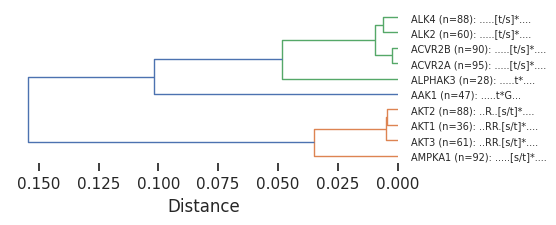

In [ ]:
plot_dendrogram(Z,dense=4,labels=labels)

## Full pipeline

In [ ]:
#| eval: false
# get distance matrix
pssms=pssms.head(100)

Z = get_Z(pssms)

# optional, get counts for each index
# count_dict = pssms.index.value_counts()

# get pssm to seq labels with counts
# labels= get_pssm_seq_labels(pssms,count_dict)

# or get pssm to seq labels only
labels= get_pssm_seq_labels(pssms)

  0%|          | 0/4950 [00:00<?, ?it/s]

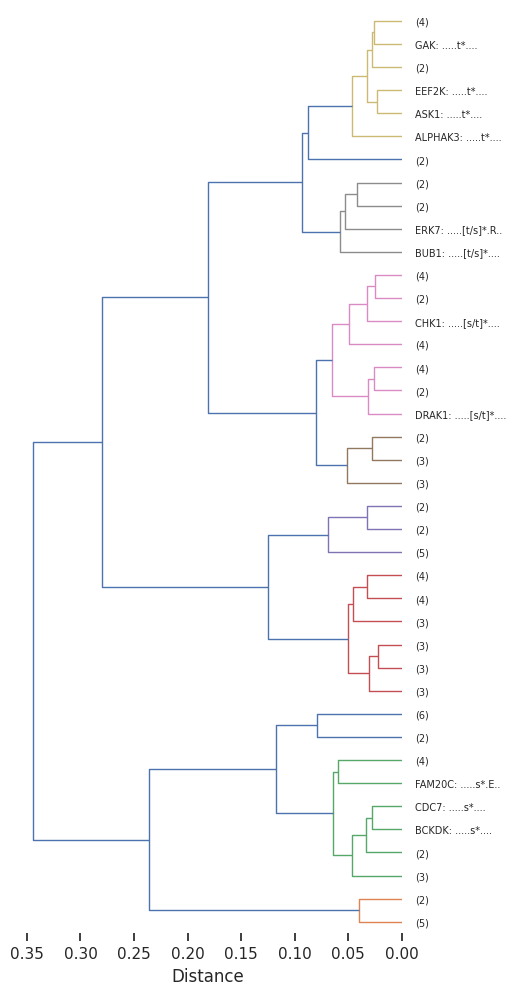

In [ ]:
# plot dendrogram
plot_dendrogram(Z,dense=8,labels=labels,truncate_mode='lastp', p=40) # only show 40

# save
# save_pdf('dendrogram.pdf')

## Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()